Clean & Encode
--------------

<div style="text-align: justify"> Data at <a href="https://www.kaggle.com/datasets/aw6ro7zcd/shells/versions/1">kaggle.com/datasets/aw6ro7zcd/shells/versions/1</a> are mixed and include simplifications and some errors. The goal of this proceeding is to clean and prepare these data to be available to use and finally, encode them to reduce their size.

Notice! If you want to run this notebook, at first you must download the data from the link above and put them into the "./raw data/" directory.

The proceeding is finished by a new dataset that can be found with entire description at <a href="https://www.kaggle.com/datasets/aw6ro7zcd/shells/versions/2">kaggle.com/datasets/aw6ro7zcd/shells/versions/2</a>.</div>

In [2]:
# Python 3.11.0

In [3]:
import os
import plotly.graph_objects as go
import pandas as pd
import plotly.io

In [4]:
ROOT: str = './raw data/'
COLUMNS: list[str] = ['Brightness',
                      'Orientation',
                      'Stripes',
                      'AntiStripes',
                      'CornerAngle',
                      'DilationAngle',
                      'Length',
                      'Width',
                      'Height']

### 1. load data

In [5]:
pages_paths: list[str] = [''.join([ROOT, file_name])\
                          for file_name in os.listdir(ROOT)]
                          
for path in pages_paths:
    print(path)

./raw data/chunk1.txt
./raw data/chunk2.txt
./raw data/chunk3.txt
./raw data/chunk4.txt
./raw data/chunk5.txt
./raw data/chunk6.txt
./raw data/chunk7.txt
./raw data/chunk8.txt


In [6]:
pages: list[pd.DataFrame] = []

### 2. rebuild the first page of data

<div style="text-align: justify">Columns on the first page are mixed, it is necessary to fit them to the rest.</div>

In [7]:
page: pd.DataFrame = pd.read_csv(filepath_or_buffer=pages_paths[0],
                                 sep='\t',
                                 names=['Length',
                                        'Width',
                                        'Height',
                                        'CornerAngle',
                                        'Stripes',
                                        'AntiStripes',
                                        'Brightness', 
                                        'Orientation',
                                        'DilationAngle'])

page.head()

,Length,Width,Height,CornerAngle,Stripes,AntiStripes,Brightness,Orientation,DilationAngle
0,"3,3","4,1",1,130,96,3,L,P,101
1,"2,6","3,6",1,125,34,8,L,P,106
2,3,"3,3","1,1",120,28,3,L,P',93
3,"1,8","2,3","0,7",115,-,7,L,P,98
4,"2,7","3,6","0,8",138,27,8,L,P,106


In [8]:
page = page.reindex(columns=COLUMNS)

page.head()

,Brightness,Orientation,Stripes,AntiStripes,CornerAngle,DilationAngle,Length,Width,Height
0,L,P,96,3,130,101,"3,3","4,1",1
1,L,P,34,8,125,106,"2,6","3,6",1
2,L,P',28,3,120,93,3,"3,3","1,1"
3,L,P,-,7,115,98,"1,8","2,3","0,7"
4,L,P,27,8,138,106,"2,7","3,6","0,8"


### 3. concatenate all pages

Now it is possible to merge all the pages.

In [9]:
# queue the pages
pages.append(page)      # the first page is already loaded
for page_path in pages_paths[1:]:
    pages.append(pd.read_csv(filepath_or_buffer=page_path,
                             sep='\t',
                             names=COLUMNS))

# merge all
data: pd.DataFrame = pd.concat(objs=pages, ignore_index=True)

print(data.shape)

(832, 9)


### 4. apply uniform notation

<div style="text-align: justify">Some of columns include various types of values i.e. P, P', 1, 0 at Orientation. However, it is better to keep uniform notation.</div>

In [10]:
# unique values
for column_name in data.columns:
    print(column_name, ': ',data[column_name].unique())

Brightness :  ['L' 'D' '-' '1' '0' 1 0]
Orientation :  ['P' "P'" '0' '1' 0 1]
Stripes :  ['96' '34' '28' '-' '27' '23' '20' '25' '18' '32' '17' '26' '80' '75' '43'
 '68' '24' '38' '44' '55' '37' '59' '45' '40' '36' '72' '86' '39' '33'
 '51' '58' '92' '30' '48' '56' '50' '22' '53' '46' '0' '47' '29' '41' '49'
 '57' '42' '52' '54' '35' '31' '21']
AntiStripes :  ['3' '8' '7' '4' '6' '9' '5' '-' '2' '13' '0' '10' '1' '11']
CornerAngle :  ['130' '125' '120' '115' '138' '135' '112' '123' '129' '95' '90' '106'
 '146' '101' '140' '-' '118' '151' '157' '128' '163']
DilationAngle :  ['101' '106' '93' '98' '112' '96' '94' '104' '-' '105' '123' '95' '108'
 '92' '91' '115' '110' '118' '90' 101 91 95 112 90 80 98 108 106 135 123
 118 100 57 63 68 74 83 89 800 51]
Length :  ['3,3' '2,6' '3' '1,8' '2,7' '2,8' '1,9' '2' '2,2' '2,5' '3,2' '3,1' '2,3'
 '2,1' '2,4' '1,6' '3,4' '1,5' '1,4' '1,7' '4' '1,2' '3,6' '1,3' '4,3'
 '2,9' '3,5' '3,7' '3,8' '3,9' '1,1']
Width :  ['4,1' '3,6' '3,3' '2,3' '3,2' '2,2' 

In [11]:
data.fillna(value='', inplace=True)     # put empty string '' where cells are NaN
for old, new in [('-', ''),
                 ('L', '1'),
                 ('D', '0'),
                 ('P', '1'),
                 ('P\'', '0')]:
    data.mask(cond=data == old, other=new, inplace=True)

In [12]:
# unique values
for column_name in data.columns:
    print(column_name, ': ',data[column_name].unique())

Brightness :  ['1' '0' '' 1 0]
Orientation :  ['1' '0' 0 1]
Stripes :  ['96' '34' '28' '' '27' '23' '20' '25' '18' '32' '17' '26' '80' '75' '43'
 '68' '24' '38' '44' '55' '37' '59' '45' '40' '36' '72' '86' '39' '33'
 '51' '58' '92' '30' '48' '56' '50' '22' '53' '46' '0' '47' '29' '41' '49'
 '57' '42' '52' '54' '35' '31' '21']
AntiStripes :  ['3' '8' '7' '4' '6' '9' '5' '' '2' '13' '0' '10' '1' '11']
CornerAngle :  ['130' '125' '120' '115' '138' '135' '112' '123' '129' '95' '90' '106'
 '146' '101' '140' '' '118' '151' '157' '128' '163']
DilationAngle :  ['101' '106' '93' '98' '112' '96' '94' '104' '' '105' '123' '95' '108'
 '92' '91' '115' '110' '118' '90' 101 91 95 112 90 80 98 108 106 135 123
 118 100 57 63 68 74 83 89 800 51]
Length :  ['3,3' '2,6' '3' '1,8' '2,7' '2,8' '1,9' '2' '2,2' '2,5' '3,2' '3,1' '2,3'
 '2,1' '2,4' '1,6' '3,4' '1,5' '1,4' '1,7' '4' '1,2' '3,6' '1,3' '4,3'
 '2,9' '3,5' '3,7' '3,8' '3,9' '1,1']
Width :  ['4,1' '3,6' '3,3' '2,3' '3,2' '2,2' '2,5' '2,9' '3' '' '4'

### 5. set data types

<div style="text-align: justify">Now, values looks as they have same type of notation per column along all lines. However, there is still discrepancy in the case of cell types.</div>

In [13]:
data = data.applymap(lambda cell: str(cell).replace(',','.'))
for column in data:
    data[column] = pd.to_numeric(arg=data[column], errors='coerce')

for column in data:
    print(column,':', data[column].dtype)
    print(sorted(data[column].unique()))

Brightness : float64
[0.0, 1.0, nan]
Orientation : int64
[0, 1]
Stripes : float64
[0.0, 17.0, 18.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 68.0, 72.0, 75.0, 86.0, 96.0, nan, 80.0, 92.0]
AntiStripes : float64
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan, 10.0, 11.0, 13.0]
CornerAngle : float64
[90.0, 95.0, 101.0, 106.0, 112.0, 115.0, 118.0, 120.0, 123.0, 125.0, 128.0, 129.0, 130.0, 135.0, 138.0, 140.0, 146.0, nan, 151.0, 157.0, 163.0]
DilationAngle : float64
[51.0, 57.0, 63.0, 68.0, 74.0, 80.0, 83.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 98.0, 100.0, 101.0, 104.0, 105.0, 106.0, 108.0, 110.0, 112.0, nan, 115.0, 118.0, 123.0, 135.0, 800.0]
Length : float64
[1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3

In [14]:
data

,Brightness,Orientation,Stripes,AntiStripes,CornerAngle,DilationAngle,Length,Width,Height
0,1.0,1,96.0,3.0,130.0,101.0,3.3,4.1,1.0
1,1.0,1,34.0,8.0,125.0,106.0,2.6,3.6,1.0
2,1.0,0,28.0,3.0,120.0,93.0,3.0,3.3,1.1
3,1.0,1,NaN,7.0,115.0,98.0,1.8,2.3,0.7
4,1.0,1,27.0,8.0,138.0,106.0,2.7,3.6,0.8
...,...,...,...,...,...,...,...,...,...
827,0.0,1,NaN,0.0,123.0,101.0,2.0,2.8,0.7
828,1.0,0,23.0,1.0,123.0,112.0,3.0,3.1,1.3
829,0.0,0,NaN,0.0,140.0,123.0,1.4,2.7,0.3
830,1.0,1,NaN,NaN,123.0,95.0,2.5,2.1,0.8


### 6. overwrite values
<div style="text-align: justify">The last step gave opportunities to visualize the data.</div>

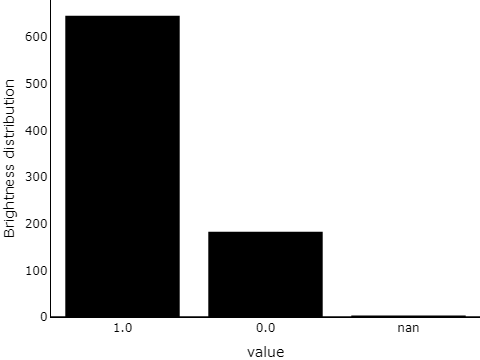

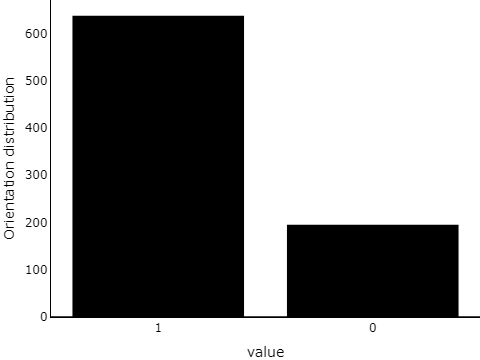

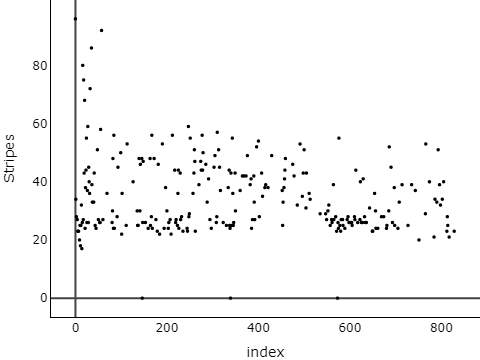

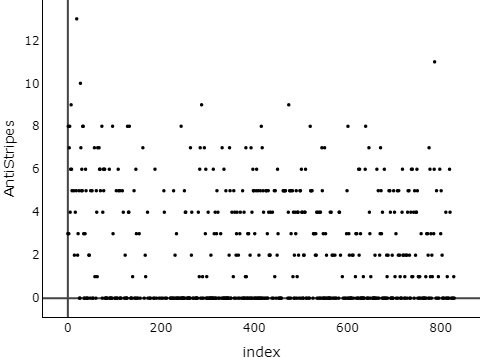

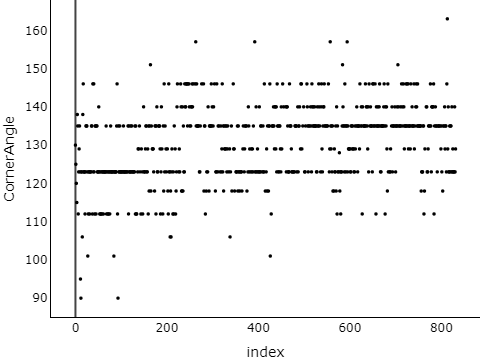

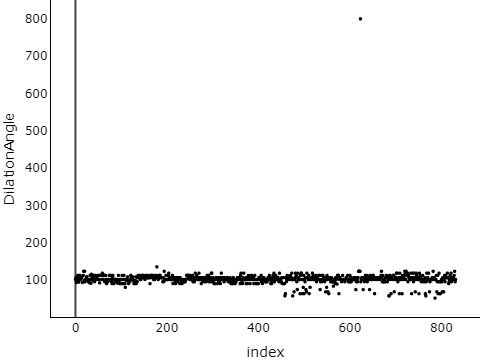

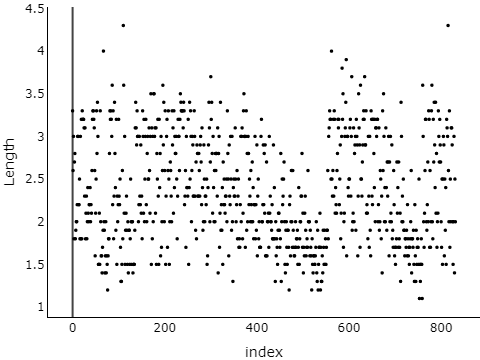

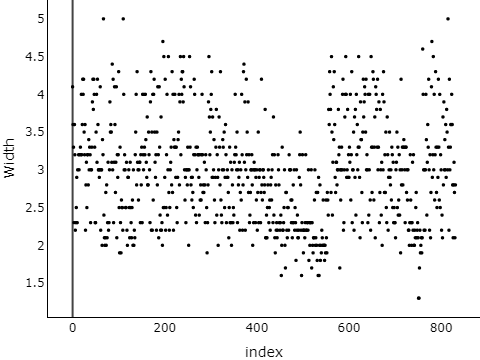

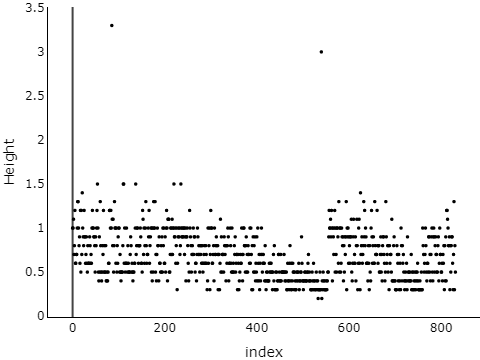

In [15]:
for column in data.columns:
    fig: go.Figure = go.Figure()
    if column not in data.columns[:2]:
        fig.add_trace(go.Scatter(
            y=data[column],
            mode='markers',
            marker=dict(size=3.5,color='black')))
        fig.update_xaxes(title_text='index')
        fig.update_yaxes(title_text=column)
    else:
        fig.add_trace(go.Histogram(
            marker={'color':'black'},
            x=data[column].astype(str),
            histnorm='',
            meta={'color':'black'}))
        fig.update_xaxes(title_text='value')
        fig.update_yaxes(title_text=column+' distribution')
    fig.update_xaxes(
        showticklabels=True,
        zerolinecolor='#444',
        linecolor="#000000",
        showline=True)
    fig.update_yaxes(
        showticklabels=True,
        zerolinecolor='#444',
        linecolor="#000000",
        showline=True)
    fig.update_layout(
        plot_bgcolor="rgba(255,255,255,0)",
        font_color="rgba(0,0,0,1)",
        paper_bgcolor="rgba(255,255,255,0)",
        showlegend=False,
        width=480,
        height=360,
        margin=dict(l=0,r=0,b=0,t=0,pad=0))
    fig.show("png")
    

<div style="text-align: justify">These figures reveals some details. One of them is that dataset DilationsAngle includes well visible, random error arose during rewriting (digitalization) measurements.</div>

In [16]:
# fix
data.loc[data['DilationAngle'] == 800, 'DilationAngle'] = 80

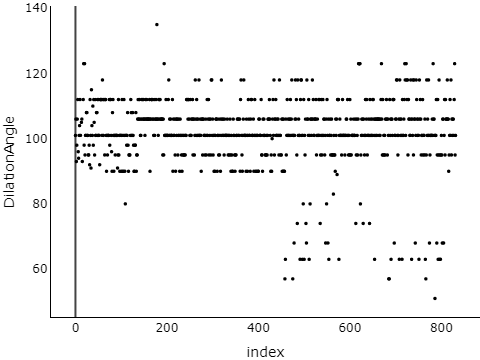

In [17]:
column = 'DilationAngle'
fig: go.Figure = go.Figure()
fig.add_trace(go.Scatter(
    y=data[column],
    mode='markers',
    marker=dict(size=3.5,color='black')))
fig.update_xaxes(
    title_text='index',
    showticklabels=True,
    zerolinecolor='#444',
    linecolor="#000000",
    showline=True)
fig.update_yaxes(
    title_text=column,
    showticklabels=True,
    zerolinecolor='#444',
    linecolor="#000000",
    showline=True)
fig.update_layout(
    plot_bgcolor="rgba(255,255,255,0)",
    font_color="rgba(0,0,0,1)",
    paper_bgcolor="rgba(255,255,255,0)",
    showlegend=False,
    width=480,
    height=360,
    margin=dict(l=0,r=0,b=0,t=0,pad=0))
fig.show('png')

<div style="text-align: justify">The same figure has also a kind of dispersion that have to be immediately fixed. For records with indices greater than ~400, some of records reach values below 90 degrees. This is caused by changed notation during collecting the data. Namely, for indices smaller than ~400, a measured angle was rounded up, to 90 degrees.</div>

In [18]:
data.loc[data['DilationAngle'] < 90.0, 'DilationAngle'] = \
    (data[data['DilationAngle'] < 90.0] + 100.0) -90.0

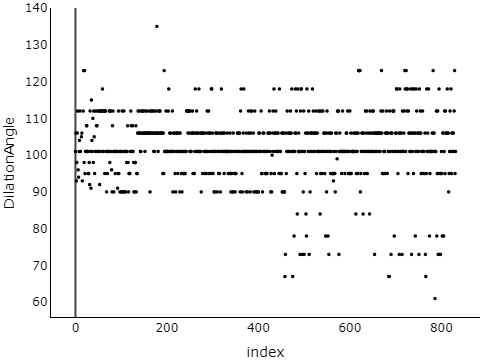

In [19]:
column = 'DilationAngle'
fig: go.Figure = go.Figure()
fig.add_trace(go.Scatter(
    y=data[column],
    mode='markers',
    marker=dict(size=3.5,color='black')))
fig.update_xaxes(
    title_text='index',
    showticklabels=True,
    zerolinecolor='#444',
    linecolor="#000000",
    showline=True)
fig.update_yaxes(
    title_text=column,
    showticklabels=True,
    zerolinecolor='#444',
    linecolor="#000000",
    showline=True)
fig.update_layout(
    plot_bgcolor="rgba(255,255,255,0)",
    font_color="rgba(0,0,0,1)",
    paper_bgcolor="rgba(255,255,255,0)",
    showlegend=False,
    width=480,
    height=360,
    margin=dict(l=0,r=0,b=0,t=0,pad=0))
fig.show('png')

<div style="text-align: justify">Exists also at least one detail that can make doubts. Columns Length, Width and Height have several hardly visible,  correlated falls. This is because of fact, that the shells was storing and measuring in several  divisions. For each division, one by one, bigger shells was measured at first and then smaller. This proceeding was not intentional, shells was segregated by themself due to Brazil Nut Effect (the size segregation in a vibrated granular material).</div>

### 7. binary form

<div style="text-align: justify">Now the data is prepared to compression. Values of each column will be encoded binary to save as many volume as it is possible.</div>

In [20]:
def describe(column: str, frame: pd.DataFrame) -> None:
    """Prints selected basic information about specified column in a data frame."""
    print('minimal value:', frame[column].min())
    print('maximal value:', frame[column].max())
    print('unique values: ', end='')
    unique: list[object] = list(frame[column].unique())
    for item in unique[:-1]:
        print(item, end=', ')
    print(unique[-1])

In [21]:
def form_binary_code(bin_number: str, number_of_digits: int) -> str:
    """Returns a given binary number without the 0b prefix, optionally leaded by zeros."""
    return bin_number.removeprefix('0b').zfill(number_of_digits)

#### 7.1 Brightness

In [22]:
describe(column='Brightness', frame=data)

minimal value: 0.0
maximal value: 1.0
unique values: 1.0, 0.0, nan


<div style="text-align: justify">
Let

- 1.0 -> 2
- 0.0 -> 1
- nan -> 0
  
So, only 2 bits are needed to store any of these values.</div>

In [23]:
print(data['Brightness'].head())
data['Brightness'] += 1
data['Brightness'] = data['Brightness'].fillna(0)
data['Brightness'] = data['Brightness'].astype(int)
data['Brightness'] = data['Brightness'].map(bin)
data['Brightness'] = data['Brightness'].map(str)
data['Brightness'] = data['Brightness'].map(lambda bin_code: form_binary_code(bin_code,2))
print(data['Brightness'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Brightness, dtype: float64
0    10
1    10
2    10
3    10
4    10
Name: Brightness, dtype: object


#### 7.2 Orientation

In [24]:
describe(column='Orientation', frame=data)

minimal value: 0
maximal value: 1
unique values: 1, 0


<div style="text-align: justify">In this case the situation is better, there is no nan values, so only 1 bit is needed.
</div>

In [25]:
print(data['Orientation'].head())
data['Orientation'] = data['Orientation'].astype(int)
data['Orientation'] = data['Orientation'].map(bin)
data['Orientation'] = data['Orientation'].map(str)
data['Orientation'] = data['Orientation'].map(lambda bin_code: form_binary_code(bin_code,1))
print(data['Orientation'].head())

0    1
1    1
2    0
3    1
4    1
Name: Orientation, dtype: int64
0    1
1    1
2    0
3    1
4    1
Name: Orientation, dtype: object


#### 7.3 Stripes

In [26]:
describe(column='Stripes', frame=data)

minimal value: 0.0
maximal value: 96.0
unique values: 96.0, 34.0, 28.0, nan, 27.0, 23.0, 20.0, 25.0, 18.0, 32.0, 17.0, 26.0, 80.0, 75.0, 43.0, 68.0, 24.0, 38.0, 44.0, 55.0, 37.0, 59.0, 45.0, 40.0, 36.0, 72.0, 86.0, 39.0, 33.0, 51.0, 58.0, 92.0, 30.0, 48.0, 56.0, 50.0, 22.0, 53.0, 46.0, 0.0, 47.0, 29.0, 41.0, 49.0, 57.0, 42.0, 52.0, 54.0, 35.0, 31.0, 21.0


<div style="text-align: justify">
There is many more unique values in form <i>xy.0</i> from span <0,96>. Let

- nan -> 0
- 0.0 -> 1
- ...
- 96.0 -> 97

keeping these values requires at least 7 bits.</div>

In [27]:
print(data['Stripes'].head())
data['Stripes'] += 1
data['Stripes'] = data['Stripes'].fillna(0)
data['Stripes'] = data['Stripes'].astype(int)
data['Stripes'] = data['Stripes'].map(bin)
data['Stripes'] = data['Stripes'].map(str)
data['Stripes'] = data['Stripes'].map(lambda bin_code: form_binary_code(bin_code,7))
print(data['Stripes'].head())

0    96.0
1    34.0
2    28.0
3     NaN
4    27.0
Name: Stripes, dtype: float64
0    1100001
1    0100011
2    0011101
3    0000000
4    0011100
Name: Stripes, dtype: object


#### 7.4 AntiStripes

In [28]:
describe(column='AntiStripes', frame=data)

minimal value: 0.0
maximal value: 13.0
unique values: 3.0, 8.0, 7.0, 4.0, 6.0, 9.0, 5.0, nan, 2.0, 13.0, 0.0, 10.0, 1.0, 11.0


<div style="text-align: justify">
Similar situation can be observed, luckily there is less unique values to encode. Let

- nan -> 0
- 0.0 -> 1
- ...
- 13.0 -> 14

4 bits are needed.</div>

In [29]:
print(data['AntiStripes'].head())
data['AntiStripes'] += 1
data['AntiStripes'] = data['AntiStripes'].fillna(0)
data['AntiStripes'] = data['AntiStripes'].astype(int)
data['AntiStripes'] = data['AntiStripes'].map(bin)
data['AntiStripes'] = data['AntiStripes'].map(str)
data['AntiStripes'] = data['AntiStripes'].map(lambda bin_code: form_binary_code(bin_code,4))
print(data['AntiStripes'].head())

0    3.0
1    8.0
2    3.0
3    7.0
4    8.0
Name: AntiStripes, dtype: float64
0    0100
1    1001
2    0100
3    1000
4    1001
Name: AntiStripes, dtype: object


#### 7.5 CornerAngle

In [30]:
describe(column='CornerAngle', frame=data)

minimal value: 90.0
maximal value: 163.0
unique values: 130.0, 125.0, 120.0, 115.0, 138.0, 135.0, 112.0, 123.0, 129.0, 95.0, 90.0, 106.0, 146.0, 101.0, 140.0, nan, 118.0, 151.0, 157.0, 128.0, 163.0


<div style="text-align: justify">
This dataset is a bit different. Apart of nan cells, they take values in form <i>xyz.0</i> from span <90, 163>. As previously, let

- nan -> 0

The angles have various values but in general, all of them should be measured and rounded to several main values with interval 5.625.</div>

In [31]:
basic_angle_interval: float = 5.625

<div style="text-align: justify">Set of the selected angles includes angle 90 degrees, so</div>

In [32]:
selected_angles = []
for multiplicity in range(0,33):
    selected_angles.append(multiplicity*basic_angle_interval)

print(selected_angles)

[0.0, 5.625, 11.25, 16.875, 22.5, 28.125, 33.75, 39.375, 45.0, 50.625, 56.25, 61.875, 67.5, 73.125, 78.75, 84.375, 90.0, 95.625, 101.25, 106.875, 112.5, 118.125, 123.75, 129.375, 135.0, 140.625, 146.25, 151.875, 157.5, 163.125, 168.75, 174.375, 180.0]


<div style="text-align: justify">Now the point is to assign all these angles that are not in the set of selected angles to their closest angles from this set.</div>

In [33]:
def find_angle(angle: float, selected_angles: list[float]) -> float:
    """Returns the closest value from the set of selected angles for a given angle."""
    absolute_distinctions: list[float] = list(map(lambda selected_angle: abs(selected_angle-angle), selected_angles))
    return selected_angles[absolute_distinctions.index(min(absolute_distinctions))]

# examples
print(find_angle(93, selected_angles))
print(find_angle(45, selected_angles))
print(find_angle(160, selected_angles))

95.625
45.0
157.5


In [34]:
# replace non-selected angles
data['CornerAngle'] = data['CornerAngle'].map(lambda angle: find_angle(angle, selected_angles), na_action='ignore')

<div style="text-align: justify">The selected angles reduces the set of available values for dataset CornerAngle. However, all of them are floating numbers which take a lot of volume. The following step enumerates them in ascending order.</div>

In [35]:
def angle_encode(angle: float, threshold: float) -> int:
    """Returns identifier of an angle."""
    return int((angle-threshold)/basic_angle_interval) + 1      # 0 reserved for the nan values

# examples
print(angle_encode(90.00, 90.00))
print(angle_encode(157.50, 90.00))
print(angle_encode(180.00, 90.00))
print(angle_encode(data['CornerAngle'].min(), data['CornerAngle'].min()))
print(angle_encode(data['CornerAngle'].max(), data['CornerAngle'].min()))

1
13
17
1
14


<div style="text-align: justify">So, a cell in dataset CornerAngle takes one of numbers from span <0,14> (the nan value or an encoded selected angle). This leads to situation, where <b>only 4 bits are needed to have kept information</b> in any cell in dataset CornerAnge, <b>instead of ~192 bits</b> (24 bytes * 8, but the size of float number depends of hardware). This is a magnificent example of data compression, especially if the dataset would be huge.</div>

In [36]:
print(data['CornerAngle'].head())
data['CornerAngle'] = data['CornerAngle']\
    .map(lambda angle: angle_encode(angle, data['CornerAngle'].min()), na_action='ignore')
data['CornerAngle'] = data['CornerAngle'].fillna(0)
data['CornerAngle'] = data['CornerAngle'].astype(int)
data['CornerAngle'] = data['CornerAngle'].map(bin)
data['CornerAngle'] = data['CornerAngle'].map(str)
data['CornerAngle'] = data['CornerAngle'].map(lambda bin_code: form_binary_code(bin_code,4))
print(data['CornerAngle'].head())

0    129.375
1    123.750
2    118.125
3    112.500
4    140.625
Name: CornerAngle, dtype: float64
0    1000
1    0111
2    0110
3    0101
4    1010
Name: CornerAngle, dtype: object


#### 7.6 DilationAngle

In [37]:
describe(column='DilationAngle',frame=data)

minimal value: 61.0
maximal value: 135.0
unique values: 101.0, 106.0, 93.0, 98.0, 112.0, 96.0, 94.0, 104.0, nan, 105.0, 123.0, 95.0, 108.0, 92.0, 91.0, 115.0, 110.0, 118.0, 90.0, 135.0, 100.0, 67.0, 73.0, 78.0, 84.0, 99.0, 61.0


<div style="text-align: justify">In here, it would be good to go the same proceeding as one in the previous section due to similarity between both datasets.</div>

In [38]:
# replace non-selected angles
data['DilationAngle'] = data['DilationAngle'].map(lambda angle: find_angle(angle, selected_angles), na_action='ignore')

In [39]:
print(angle_encode(data['DilationAngle'].max(), data['DilationAngle'].min()))

14


<div style="text-align: justify">The situation is the same as in the previous section namely, a cell in dataset DilationAngle takes one of numbers from span <0,14> (the nan value or an encoded selected angle). So only 4 bits are required to have kept information in any cell in dataset DilationAnge.</div>

In [40]:
print(data['DilationAngle'].head())
data['DilationAngle'] = data['DilationAngle']\
    .map(lambda angle: angle_encode(angle, data['DilationAngle'].min()), na_action='ignore')
data['DilationAngle'] = data['DilationAngle'].fillna(0)
data['DilationAngle'] = data['DilationAngle'].astype(int)
data['DilationAngle'] = data['DilationAngle'].map(bin)
data['DilationAngle'] = data['DilationAngle'].map(str)
data['DilationAngle'] = data['DilationAngle'].map(lambda bin_code: form_binary_code(bin_code,4))
print(data['DilationAngle'].head())

0    101.250
1    106.875
2     95.625
3     95.625
4    106.875
Name: DilationAngle, dtype: float64
0    1000
1    1001
2    0111
3    0111
4    1001
Name: DilationAngle, dtype: object


#### 7.7 Length

In [41]:
describe(column='Length', frame=data)

minimal value: 1.1
maximal value: 4.3
unique values: 3.3, 2.6, 3.0, 1.8, 2.7, 2.8, 1.9, 2.0, 2.2, 2.5, 3.2, 3.1, 2.3, 2.1, 2.4, 1.6, 3.4, 1.5, 1.4, 1.7, 4.0, 1.2, 3.6, 1.3, 4.3, 2.9, 3.5, 3.7, 3.8, 3.9, 1.1


<div style="text-align: justify">As it can be observed, in this dataset there is no the nan values and all unique of them are in form of <i>x.y</i>. It would be rightly to convert them into integers.</div>

In [42]:
data['Length'] *= 10

print(data['Length'].min())
print(data['Length'].max())

11.0
43.0


<div style="text-align: justify">Unfortunately, reduction about 11.0 will not allow to reduce the smallest number of required bits. There is 6 of them.</div>

In [43]:
print(data['Length'].head())
data['Length'] = data['Length'].astype(int)
data['Length'] = data['Length'].map(bin)
data['Length'] = data['Length'].map(str)
data['Length'] = data['Length'].map(lambda bin_code: form_binary_code(bin_code,6))
print(data['Length'].head())

0    33.0
1    26.0
2    30.0
3    18.0
4    27.0
Name: Length, dtype: float64
0    100001
1    011010
2    011110
3    010010
4    011011
Name: Length, dtype: object


#### 7.8 Width

In [44]:
describe(column='Width', frame=data)

minimal value: 1.3
maximal value: 5.0
unique values: 4.1, 3.6, 3.3, 2.3, 3.2, 2.2, 2.5, 2.9, 3.0, nan, 4.0, 4.2, 3.5, 2.8, 3.1, 3.4, 3.9, 3.8, 2.0, 5.0, 2.4, 2.1, 2.7, 4.4, 4.3, 1.9, 2.6, 3.7, 4.7, 4.5, 1.6, 1.7, 1.8, 1.3, 4.6


<div style="text-align: justify">In here it is possible to go as previously however, the nan value is found.</div>

In [45]:
data['Width'] *= 10

print(data['Width'].min())
print(data['Width'].max())

13.0
50.0


<div style="text-align: justify">And in this situation, reduction by 12 will not give any benefits, 6 bits are needed at least. Let the nan -> 0.</div>

In [46]:
print(data['Width'].head())
data['Width'] = data['Width'].fillna(0)
data['Width'] = data['Width'].astype(int)
data['Width'] = data['Width'].map(bin)
data['Width'] = data['Width'].map(str)
data['Width'] = data['Width'].map(lambda bin_code: form_binary_code(bin_code,6))
print(data['Width'].head())

0    41.0
1    36.0
2    33.0
3    23.0
4    36.0
Name: Width, dtype: float64
0    101001
1    100100
2    100001
3    010111
4    100100
Name: Width, dtype: object


#### 7.9 Height

In [47]:
describe(column='Height', frame=data)

minimal value: 0.2
maximal value: 3.3
unique values: 1.0, 1.1, 0.7, 0.8, 1.2, 0.6, 1.3, 0.9, 0.5, 1.4, 1.5, 0.4, 3.3, 0.3, 0.2, 3.0


<div style="text-align: justify">In the last dataset, it is possible to have kept information only in 5 bits. There is no the nan values, but each value must be an integer reduced about the minimal value.</div>

In [48]:
print(data['Height'].head())
data['Height'] *= 10
data['Height'] = data['Height'] - data['Height'].min()
data['Height'] = data['Height'].astype(int)
data['Height'] = data['Height'].map(bin)
data['Height'] = data['Height'].map(str)
data['Height'] = data['Height'].map(lambda bin_code: form_binary_code(bin_code,5))
print(data['Height'].head())

0    1.0
1    1.0
2    1.1
3    0.7
4    0.8
Name: Height, dtype: float64
0    01000
1    01000
2    01001
3    00101
4    00110
Name: Height, dtype: object


### 8. write

In [49]:
data.head()

,Brightness,Orientation,Stripes,AntiStripes,CornerAngle,DilationAngle,Length,Width,Height
0,10,1,1100001,0100,1000,1000,100001,101001,01000
1,10,1,0100011,1001,0111,1001,011010,100100,01000
2,10,0,0011101,0100,0110,0111,011110,100001,01001
3,10,1,0000000,1000,0101,0111,010010,010111,00101
4,10,1,0011100,1001,1010,1001,011011,100100,00110


<div style="text-align: justify">Finally, the data is ready to be written.</div>

In [50]:
with open('data.bin', mode='wb') as file:
    buffer: str = ''
    frame_size: int = 7

    def flush_buffer() -> None:
        global buffer
        global frame_size
        while (len(buffer) // frame_size) >= 1:
            file.write(bytes([int(buffer[:frame_size], base=2)]))
            buffer = buffer[frame_size:]

    for row_index in range(len(data)):
        for column_index in range(len(data.columns)):
            buffer += data.iloc[row_index, column_index]        # append next bits
        flush_buffer()

    buffer = buffer.ljust(frame_size,'0')       # complement the last frame
    flush_buffer()
